# k-Nearest Neighbor Model Analysis Walkthrough (Low Gravity)

The k-Nearest Neighbors (k-NN) algorithm is one of the simplest yet powerful supervised machine learning techniques. Fundamentally non-parametric, it doesn't make strong assumptions about the functional form of the data. Instead, k-NN relies on instance-based learning, which means it memorizes instances from the training data and uses them directly for prediction.

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report, make_scorer, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from pathlib import Path

In [2]:
# this is the path to your pickle file (should be the same location as CSVs)
path = Path('../../data')

with open(path / 'low_g_pandas_2.0.2.pkl', 'rb') as file:
    df = pickle.load(file)
df = df.reset_index(drop=True)

## Dataset Splitting
We begin by splitting our dataset into a training and testing set. This process ensures that we have a distinct set of data to evaluate the model's performance.

In [3]:
# define independent variables and dependent variable
maneuver = 'LOW-G'
X = df.drop(maneuver, axis=1)
y = df[maneuver]

In [4]:
# splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Build and Fit the Model
We will set up a parameter grid with the best parameters. These parameters were developed in the modeling directory in the decision tree (dynamic rollover) file. For more information on the training and tuning of this model please refer to the modeling file.

In [5]:
# pipe_with_rus = ImbPipeline([
#     ('scaler', StandardScaler()),
#     ('under', RandomUnderSampler(random_state=42)),
#     ('knn', KNeighborsClassifier())
# ])

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])


In [6]:
params = {
    'knn__n_neighbors': [3], #  list(range(1, 11))
    'knn__weights': ['distance'],  # 'uniform'
    'knn__p': [1],  # 2
    'knn__n_jobs': [-1]
}

In [7]:
f1_scorer = make_scorer(f1_score)
strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=pipe, param_grid=params, cv=strat_k_fold, scoring=f1_scorer)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_jobs': [-1], 'knn__n_neighbors': [3],
                         'knn__p': [1], 'knn__weights': ['distance']},
             scoring=make_scorer(f1_score))

## Make Predictions for Model Evaluation

In [8]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     51437
           1     0.9971    1.0000    0.9985       344

    accuracy                         1.0000     51781
   macro avg     0.9986    1.0000    0.9993     51781
weighted avg     1.0000    1.0000    1.0000     51781



In [9]:
print(confusion_matrix(y_test, y_pred))

[[51436     1]
 [    0   344]]


## Visualizations
These visualizations will provide a comprehensive understanding of the model's performance, the features that drive decisions, and how the model's performance evolves as more data is added.

### ROC Curve
The Receiver Operating Characteristic (ROC) Curve is a graphical representation that showcases the diagnostic ability of a binary classifier as its discrimination threshold varies. The ROC curve is created by plotting the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings.

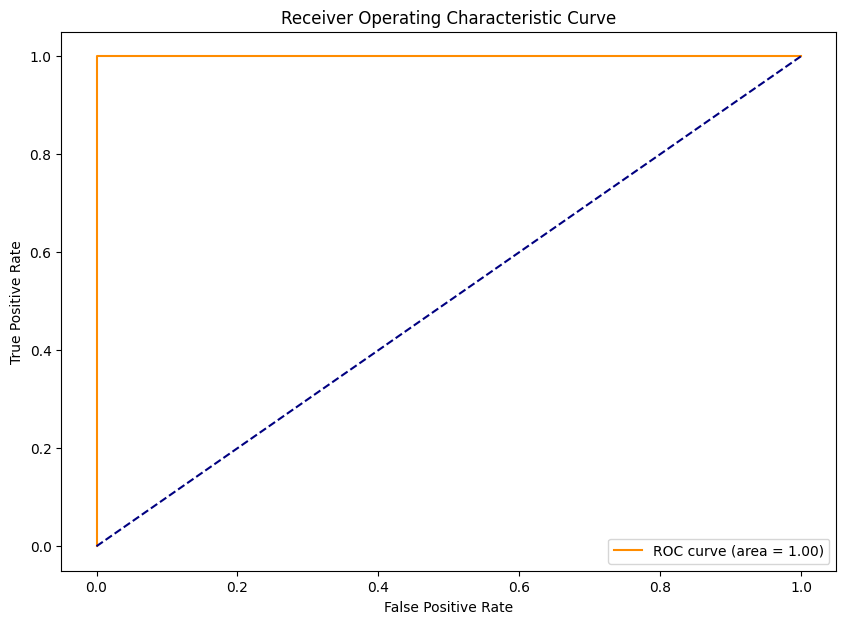

In [10]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

### Histogram or Density Plot of Distance to Nearest Neighbors

Let's visualize the distribution of distances to the nearest neighbors. This will give insights into how close the test data points are to their nearest neighbors in the training dataset.

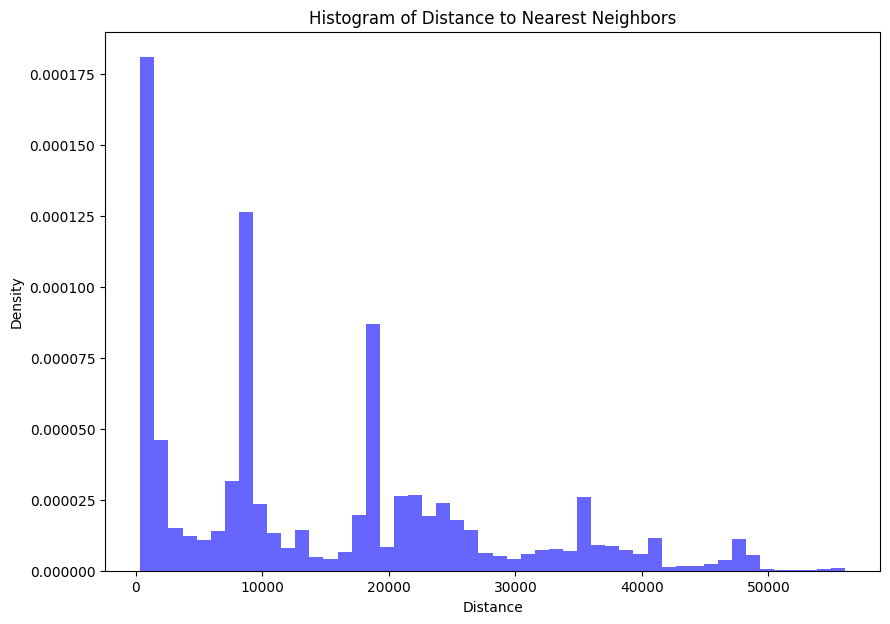

In [11]:
# Calculate distances
distances, _ = best_model.named_steps['knn'].kneighbors(X_test.values)

# Plot
plt.figure(figsize=(10,7))
plt.hist(distances[:, 0], bins=50, density=True, alpha=0.6, color='b')
plt.title('Histogram of Distance to Nearest Neighbors')
plt.xlabel('Distance')
plt.ylabel('Density')
plt.show()

## Analysis Summary:
### ROC Curve Analysis: 
The ROC curve for our k-Nearest Neighbors (k-NN) model has an AUC (Area Under the Curve) of 1.0. While an AUC of 1.0 typically indicates perfect classification capabilities, it can also be a warning sign. In a real-world scenario, obtaining such a score can be suspicious and might suggest that our model is too good to be true.

### Histogram/Density Plot Analysis: 
Our examination of the Histogram or Density Plot of the Distance to Nearest Neighbors reveals several sharp and high peaks. While such peaks can indicate distinct clusters in the data, their pronounced and narrow nature raises concerns. Specifically, these sharp peaks might indicate that the k-NN model is overfitting to the training data. Overfitting refers to the scenario where the model performs exceptionally well on the training data but may struggle to generalize to new, unseen data. It essentially means that our model might be capturing noise or anomalies in the training data, thinking of them as patterns.

### Overall Conclusion: 
Given the perfect AUC of 1.0 and the sharp peaks observed in the distance distribution, there's a significant risk that our k-NN model is overfitting. While it might deliver impressive results on our current dataset, its performance on new data might not be as robust. We should consider strategies to mitigate overfitting, such as introducing regularization, using a simpler model, or obtaining more diverse training data. Furthermore, cross-validation on different subsets of the data and testing the model on entirely new datasets can provide more insight into its generalization capabilities.